In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso

# Data aggregation

In [22]:
df_bike_trips = pd.read_parquet('../../data/bike_trips_cleaned.parquet')
df_bike_trips.head()

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,end_station_name,start_station_name,duration,start_lat,start_lon,end_lat,end_lon,distance,speed,average_time,max_temp,min_temp,precip
index,,,,,,,,,,,,,,,,,,,
0,2016-01-01 00:04:00,2016-01-01 00:14:00,3046,3041,3564,Indego30,"Girard Station, MFL",2nd & Market,0 days 00:10:00,39.949895,-75.143749,39.969241,-75.136180,1.005648,6.033888,2016-01-01 00:09:00,6.7,6.7,0.0
1,2016-01-01 00:07:00,2016-01-01 00:29:00,3028,3019,2629,Indego30,6th & Race,4th & Bainbridge,0 days 00:22:00,39.940735,-75.149370,39.954694,-75.149496,0.397798,1.084905,2016-01-01 00:18:00,6.7,6.7,0.0
2,2016-01-01 00:14:00,2016-01-01 00:27:00,3007,3066,3430,Indego30,19th & Lombard,"11th & Pine, Kahn Park",0 days 00:13:00,39.945123,-75.159952,39.945664,-75.173272,1.480278,6.832050,2016-01-01 00:20:30,6.7,6.7,0.0
3,2016-01-01 00:20:00,2016-01-01 00:30:00,3045,3028,3715,Indego30,4th & Bainbridge,13th & Locust,0 days 00:10:00,39.947947,-75.162361,39.940735,-75.149370,1.458133,8.748797,2016-01-01 00:25:00,6.7,6.7,0.0
4,2016-01-01 00:20:00,2016-01-01 00:42:00,3005,3064,3351,Walk-up,"18th & Washington, Chew Playground","Welcome Park, NPS",0 days 00:22:00,39.947383,-75.144145,39.938280,-75.173873,3.313616,9.037136,2016-01-01 00:31:00,7.2,7.2,0.0


In [23]:
# floor start and end times of trips to hour value, i.e. ignore minutes and seconds
df_bike_trips['start_time_floored'] = df_bike_trips['start_time'].dt.floor('H')
df_bike_trips['end_time_floored'] = df_bike_trips['end_time'].dt.floor('H')

df_bike_trips.head(70)

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,end_station_name,start_station_name,duration,start_lat,...,end_lat,end_lon,distance,speed,average_time,max_temp,min_temp,precip,start_time_floored,end_time_floored
index,,,,,,,,,,,,,,,,,,,,,
0,2016-01-01 00:04:00,2016-01-01 00:14:00,3046,3041,3564,Indego30,"Girard Station, MFL",2nd & Market,0 days 00:10:00,39.949895,...,39.969241,-75.136180,1.005648,6.033888,2016-01-01 00:09:00,6.7,6.7,0.0,2016-01-01 00:00:00,2016-01-01 00:00:00
1,2016-01-01 00:07:00,2016-01-01 00:29:00,3028,3019,2629,Indego30,6th & Race,4th & Bainbridge,0 days 00:22:00,39.940735,...,39.954694,-75.149496,0.397798,1.084905,2016-01-01 00:18:00,6.7,6.7,0.0,2016-01-01 00:00:00,2016-01-01 00:00:00
2,2016-01-01 00:14:00,2016-01-01 00:27:00,3007,3066,3430,Indego30,19th & Lombard,"11th & Pine, Kahn Park",0 days 00:13:00,39.945123,...,39.945664,-75.173272,1.480278,6.832050,2016-01-01 00:20:30,6.7,6.7,0.0,2016-01-01 00:00:00,2016-01-01 00:00:00
3,2016-01-01 00:20:00,2016-01-01 00:30:00,3045,3028,3715,Indego30,4th & Bainbridge,13th & Locust,0 days 00:10:00,39.947947,...,39.940735,-75.149370,1.458133,8.748797,2016-01-01 00:25:00,6.7,6.7,0.0,2016-01-01 00:00:00,2016-01-01 00:00:00
4,2016-01-01 00:20:00,2016-01-01 00:42:00,3005,3064,3351,Walk-up,"18th & Washington, Chew Playground","Welcome Park, NPS",0 days 00:22:00,39.947383,...,39.938280,-75.173873,3.313616,9.037136,2016-01-01 00:31:00,7.2,7.2,0.0,2016-01-01 00:00:00,2016-01-01 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,2016-01-01 02:02:00,2016-01-01 02:16:00,3041,3041,3560,Walk-up,"Girard Station, MFL","Girard Station, MFL",0 days 00:14:00,39.969241,...,39.969241,-75.136180,0.000000,0.000000,2016-01-01 02:09:00,6.7,6.7,0.0,2016-01-01 02:00:00,2016-01-01 02:00:00
66,2016-01-01 01:58:00,2016-01-01 02:21:00,3052,3070,3555,Walk-up,"Spring Garden Station, MFL",9th & Locust,0 days 00:23:00,39.947164,...,39.960541,-75.140359,1.788087,4.664576,2016-01-01 02:09:30,6.7,6.7,0.0,2016-01-01 01:00:00,2016-01-01 02:00:00
67,2016-01-01 01:59:00,2016-01-01 02:21:00,3052,3070,3440,Walk-up,"Spring Garden Station, MFL",9th & Locust,0 days 00:22:00,39.947164,...,39.960541,-75.140359,1.788087,4.876602,2016-01-01 02:10:00,6.7,6.7,0.0,2016-01-01 01:00:00,2016-01-01 02:00:00


In [24]:
# calculate the number of starting and ending trips for each hour
starting_trips_grouped = (
    df_bike_trips.groupby(["start_time_floored"])
    .size()
    .to_frame("starting_trips")
)
ending_trips_grouped = (
    df_bike_trips.groupby(["end_time_floored"])
    .size()
    .to_frame("ending_trips")
)

df_bike_trips.head()

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,end_station_name,start_station_name,duration,start_lat,...,end_lat,end_lon,distance,speed,average_time,max_temp,min_temp,precip,start_time_floored,end_time_floored
index,,,,,,,,,,,,,,,,,,,,,
0,2016-01-01 00:04:00,2016-01-01 00:14:00,3046,3041,3564,Indego30,"Girard Station, MFL",2nd & Market,0 days 00:10:00,39.949895,...,39.969241,-75.136180,1.005648,6.033888,2016-01-01 00:09:00,6.7,6.7,0.0,2016-01-01,2016-01-01
1,2016-01-01 00:07:00,2016-01-01 00:29:00,3028,3019,2629,Indego30,6th & Race,4th & Bainbridge,0 days 00:22:00,39.940735,...,39.954694,-75.149496,0.397798,1.084905,2016-01-01 00:18:00,6.7,6.7,0.0,2016-01-01,2016-01-01
2,2016-01-01 00:14:00,2016-01-01 00:27:00,3007,3066,3430,Indego30,19th & Lombard,"11th & Pine, Kahn Park",0 days 00:13:00,39.945123,...,39.945664,-75.173272,1.480278,6.832050,2016-01-01 00:20:30,6.7,6.7,0.0,2016-01-01,2016-01-01
3,2016-01-01 00:20:00,2016-01-01 00:30:00,3045,3028,3715,Indego30,4th & Bainbridge,13th & Locust,0 days 00:10:00,39.947947,...,39.940735,-75.149370,1.458133,8.748797,2016-01-01 00:25:00,6.7,6.7,0.0,2016-01-01,2016-01-01
4,2016-01-01 00:20:00,2016-01-01 00:42:00,3005,3064,3351,Walk-up,"18th & Washington, Chew Playground","Welcome Park, NPS",0 days 00:22:00,39.947383,...,39.938280,-75.173873,3.313616,9.037136,2016-01-01 00:31:00,7.2,7.2,0.0,2016-01-01,2016-01-01


In [25]:
# combine these values into a single dataframe and determine whether data cleaning is necessary
df_bike_trips_hourly = pd.concat([starting_trips_grouped, ending_trips_grouped], axis=1)
df_bike_trips_hourly.isna().sum()
#df_bike_trips_hourly.tail()

starting_trips    54
ending_trips      43
dtype: int64

In [26]:
df_bike_trips_hourly = df_bike_trips_hourly.fillna(0) 
df_bike_trips_hourly.isna().sum()
#df_bike_trips_hourly.tail()

starting_trips    0
ending_trips      0
dtype: int64

In [27]:
df_bike_trips_hourly.to_parquet('../../data/bike_trips_hourly.parquet')

# Feature engineering

In [28]:
df_bike_trips_hourly.head()

,starting_trips,ending_trips
2016-01-01 00:00:00,26.0,17.0
2016-01-01 01:00:00,39.0,32.0
2016-01-01 02:00:00,33.0,37.0
2016-01-01 03:00:00,6.0,10.0
2016-01-01 04:00:00,1.0,1.0


### Add weather features

In [29]:
df_weather = pd.read_parquet('../../data/weather_hourly_philadelphia_cleaned.parquet')
#df_weather.head()
print(len(df_weather))

8312


In [30]:
df_bike_trips_hourly['max_temp'] = df_weather['max_temp']
df_bike_trips_hourly['min_temp'] = df_weather['min_temp']
df_bike_trips_hourly['precip'] = df_weather['precip']
df_bike_trips_hourly.isna().sum()
print(len(df_bike_trips_hourly))
#df_bike_trips_hourly.head()

8588


In [31]:
#drop null values
df_bike_trips_hourly = df_bike_trips_hourly.dropna()
print(len(df_bike_trips_hourly))

8124


### Time related features

In [32]:
#
df_bike_trips_hourly['hour'] = df_bike_trips_hourly.index.hour
df_bike_trips_hourly['day_of_week'] = df_bike_trips_hourly.index.day_of_week
df_bike_trips_hourly['month'] = df_bike_trips_hourly.index.month
df_bike_trips_hourly['day_of_year'] = df_bike_trips_hourly.index.day_of_year
df_bike_trips_hourly['week'] = df_bike_trips_hourly.index.isocalendar().week.astype('int64')
df_bike_trips_hourly['is_weekday'] = df_bike_trips_hourly['day_of_week'] < 5
#is_weekday as binary variable
df_bike_trips_hourly['is_weekday'] = df_bike_trips_hourly['is_weekday'].astype(int)
df_bike_trips_hourly['date'] = df_bike_trips_hourly.index.date.astype('datetime64[ns]')
df_bike_trips_hourly.head()

,starting_trips,ending_trips,max_temp,min_temp,precip,hour,day_of_week,month,day_of_year,week,is_weekday,date
2016-01-01 00:00:00,26.0,17.0,6.7,6.7,0.0,0,4,1,1,53,1,2016-01-01
2016-01-01 01:00:00,39.0,32.0,7.2,7.2,0.0,1,4,1,1,53,1,2016-01-01
2016-01-01 02:00:00,33.0,37.0,6.7,6.7,0.0,2,4,1,1,53,1,2016-01-01
2016-01-01 03:00:00,6.0,10.0,6.7,6.7,0.0,3,4,1,1,53,1,2016-01-01
2016-01-01 04:00:00,1.0,1.0,6.1,6.1,0.0,4,4,1,1,53,1,2016-01-01


In [33]:
df_bike_trips_hourly.to_parquet('../../data/bike_trips_hourly.parquet')

# Correlation

In [34]:
df_bike_trips_hourly.corr()

,starting_trips,ending_trips,max_temp,min_temp,precip,hour,day_of_week,month,day_of_year,week,is_weekday
starting_trips,1.000000,0.986824,0.367385,0.367965,-0.112003,0.339070,-0.086754,0.225140,0.221598,0.202131,0.112407
ending_trips,0.986824,1.000000,0.383563,0.384222,-0.116387,0.365555,-0.086422,0.227017,0.223475,0.203810,0.111463
max_temp,0.367385,0.383563,1.000000,0.999684,-0.072206,0.147838,-0.006414,0.211212,0.212795,0.179991,0.016651
min_temp,0.367965,0.384222,0.999684,1.000000,-0.079202,0.146652,-0.006564,0.211436,0.213032,0.180394,0.016850
precip,-0.112003,-0.116387,-0.072206,-0.079202,1.000000,0.013636,-0.009228,-0.051463,-0.052260,-0.060522,-0.002292
hour,0.339070,0.365555,0.147838,0.146652,0.013636,1.000000,-0.003396,-0.014466,-0.014305,-0.013921,0.002290
day_of_week,-0.086754,-0.086422,-0.006414,-0.006564,-0.009228,-0.003396,1.000000,-0.008580,-0.008388,0.002763,-0.787167
month,0.225140,0.227017,0.211212,0.211436,-0.051463,-0.014466,-0.008580,1.000000,0.996513,0.946965,0.004658
day_of_year,0.221598,0.223475,0.212795,0.213032,-0.052260,-0.014305,-0.008388,0.996513,1.000000,0.946826,0.004154
week,0.202131,0.203810,0.179991,0.180394,-0.060522,-0.013921,0.002763,0.946965,0.946826,1.000000,-0.005945


<AxesSubplot:>

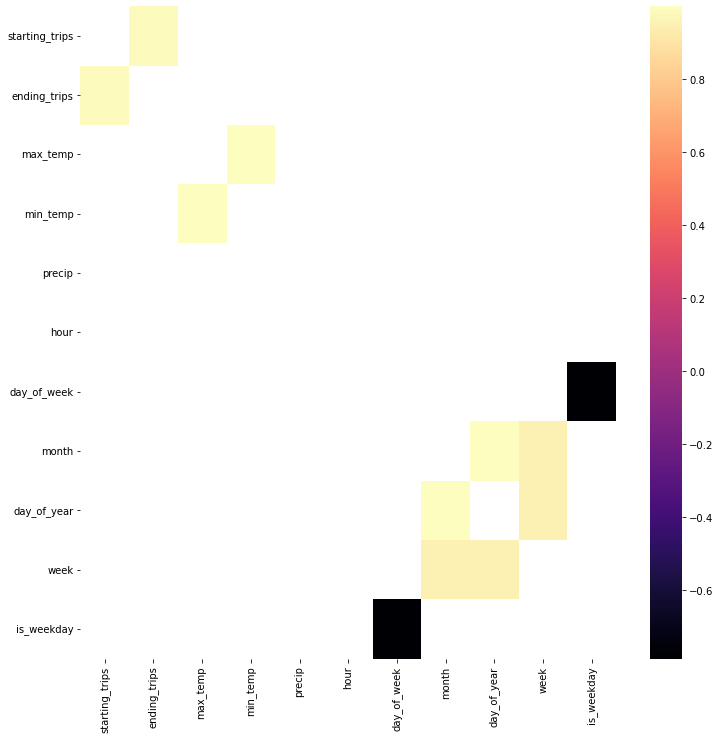

In [35]:
corr = df_bike_trips_hourly.corr()

#kot = corr[((corr>=.7) or (corr<=-.7))]
kot = corr[((corr >= .7) | (corr <= -.7)) & (corr !=1.000)]
plt.figure(figsize=(12,12))
sns.heatmap(kot, cmap="magma")

In [36]:
def corrFilter(x: pd.DataFrame, bound: float):
    xCorr = x.corr()
    xFiltered = xCorr[((xCorr >= bound) | (xCorr <= -bound)) & (xCorr !=1.000)]
    xFlattened = xFiltered.unstack().sort_values().drop_duplicates()
    return xFlattened

corrFilter(df_bike_trips_hourly, .7)

day_of_week     is_weekday       -0.787167
day_of_year     week              0.946826
month           week              0.946965
starting_trips  ending_trips      0.986824
month           day_of_year       0.996513
max_temp        min_temp          0.999684
starting_trips  starting_trips         NaN
dtype: float64

# Drop features

Looking at the *Correlation* seven pairs have high correlation. So either one of them can be dropped. The features that we will drop are: day_of_week, max_temp. For three pairs we see different correlation "relationships": day_of_year, as well as month correlate highly to week and month also correlates highly to day_of_year. So the one feature that we will keep is the month, as we also looked at it in our descriptive analytics. The starting_trips can be ignored in this case, as the correlation with the variable itself is always 1.

In [41]:
columns_to_drop = ['max_temp', 'day_of_week', 'day_of_year', 'week']
df_bike_trips_hourly.drop(columns_to_drop, axis=1, inplace=True)
df_bike_trips_hourly.head()

,starting_trips,ending_trips,min_temp,precip,hour,month,is_weekday,date
2016-01-01 00:00:00,26.0,17.0,6.7,0.0,0,1,1,2016-01-01
2016-01-01 01:00:00,39.0,32.0,7.2,0.0,1,1,1,2016-01-01
2016-01-01 02:00:00,33.0,37.0,6.7,0.0,2,1,1,2016-01-01
2016-01-01 03:00:00,6.0,10.0,6.7,0.0,3,1,1,2016-01-01
2016-01-01 04:00:00,1.0,1.0,6.1,0.0,4,1,1,2016-01-01


In [42]:
df_bike_trips_hourly.to_parquet('../../data/bike_trips_hourly.parquet')

# Lasso regression

In [37]:
#input_features = df_bike_trips_hourly.reset_index().drop(columns=["starting_trips"])
#predicted_varible = df_bike_trips_hourly["starting_trips"]

In [38]:
# scale input features
#scaler = StandardScaler()
#input_features_scaled = scaler.fit_transform(input_features.values)

In [39]:
# fit data to the linear regression model
#model = Lasso(alpha=1)
#model.fit(input_features_scaled, predicted_varible)
#print("Coefficients ", model.coef_)

In [40]:
#trips_hourly_df = trips_hourly_df.drop(columns={"precip", "day_of_week"})